# DATA 604 HW6

Magnus Skonberg

These exercises and their solutions were made with reference to *Modeling and Simulation in Python* (version 3) authored by Allen B. Downey. This week's exercises focused on **Optimization**, chapters 12 and 13 of the text.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Chapter 12
### Previous Code

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

### Metrics

We can compute metrics to quantify what we're interested in, like the total number of sick students, for example.

In [3]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

In [4]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.46716293183605073


### Exercise 

Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [10]:
# 1. The fraction of students who are sick at the peak of the outbreak.
def frac_sick_peak(results):
    return results.I.max()

# 2. The day the outbreak peaks.
def peak_day(results):
    return results.I.idxmax()

# 3. The fraction of students who are sick at the end of the semester.
def frac_sick_end(results):
    return get_last_value(results.I)

#verify that they work
print(frac_sick_peak(results), peak_day(results), frac_sick_end(results))

0.043536202687592354 30 0.0006741943156034474


From above we could extend that:
* the fraction of students who are sick at the peak of the outbreak: 0.0435
* the day the outbreak peaks: 30
* the fraction of students who are sick at the end of the semester: 0.000674

### What if?

Now we account for the impact of immunization:

Saving figure to file figs/chap12-fig01.pdf


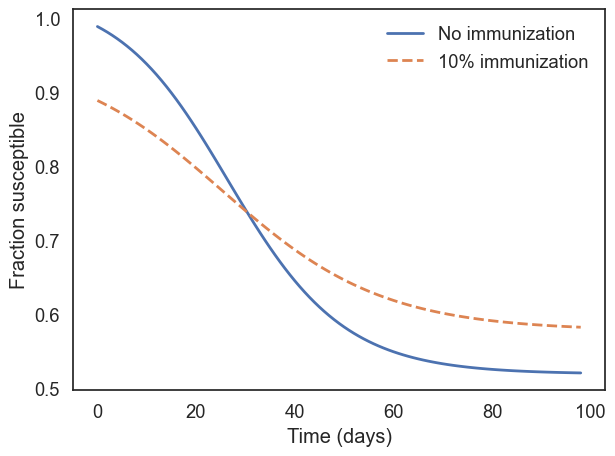

In [11]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

#initialize variables
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

#run model without immunization
results = run_simulation(system, update_func)
calc_total_infected(results)

#run model with 10% immunization
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

#plot results / difference
plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap12-fig01.pdf')

Saving figure to file figs/chap12-fig02.pdf


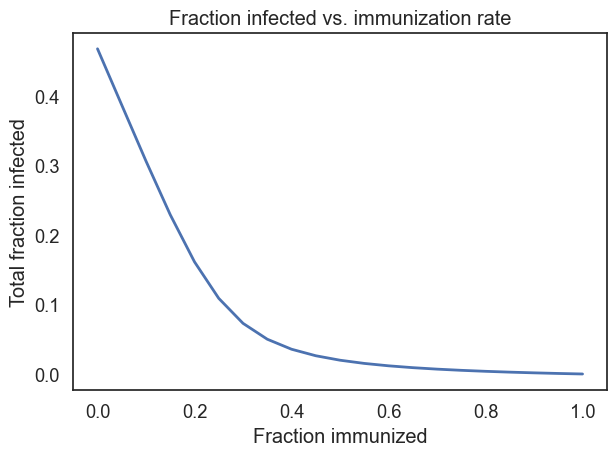

In [12]:
#Define sweep immunization function
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

#Sweep through range of values for the fraction of the population who are immunized.
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

#Plot results
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap12-fig02.pdf')

### Logistic Function

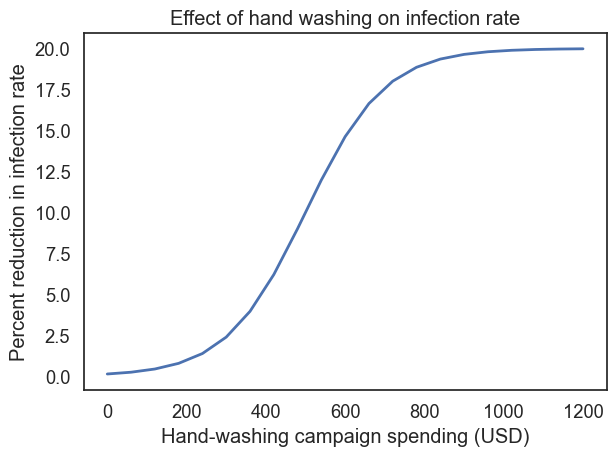

In [30]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

spending = linspace(0, 1200, 21) #range of possible spending

def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

### Exercise

Modify the parameters M, K, and B, and see what effect they have on the shape of the curve. Modify the other parameters and see what effect they have.

Notes on modifying parameters:

* **M**: being that 'M' controls the location of the transition, when we increase it the sigmoid shifts right along the X axis and when we reduce it the sigmoid shifts left along the X axis with the midpoint (of the sigmoid) being situated over the specified value.
* **K**: being that 'K' controls the upper bound, when we increase it the maximum value of the Y axis shifts ip and when we reduce it the maximum value shifts down, with the sigmoid reaching its apex at the specified value.
* **B**: being that 'B' controls the steepness of the transition, when we increase it the transition is quicker from the minimum Y value to maximum Y value (fewer increments of X) and when we decrease it the transition is slower from minimum Y value to maximum Y value (more increments of X).
* **Other values**: when we vary 'A' the lower bound follows, when we vary 'C' the Y value is impacted, when we vary 'Q' the X value is impacted, and when we vary 'nu' the location of transition and slope vary.

### Handwashing

We'll explore the effect hand-washing has on our model and then put it all together:

0.0 0.3328871432717143 0.4667702312363652
100.0 0.3321342526691939 0.46414165040064037
200.0 0.33017160845482885 0.4572170063132055
300.0 0.32538647186519215 0.4398872029120663
400.0 0.3154039052420003 0.40163064627138245
500.0 0.3 0.3370342594898199
600.0 0.28459609475799963 0.26731703056804546
700.0 0.2746135281348078 0.22184699045990752
800.0 0.26982839154517113 0.20079159841614402
900.0 0.2678657473308061 0.1923921833925878
1000.0 0.26711285672828566 0.18921320781833872
1100.0 0.26683150821044227 0.18803175228016467
1200.0 0.26672740341296003 0.1875955039953746
Saving figure to file figs/chap12-fig03.pdf


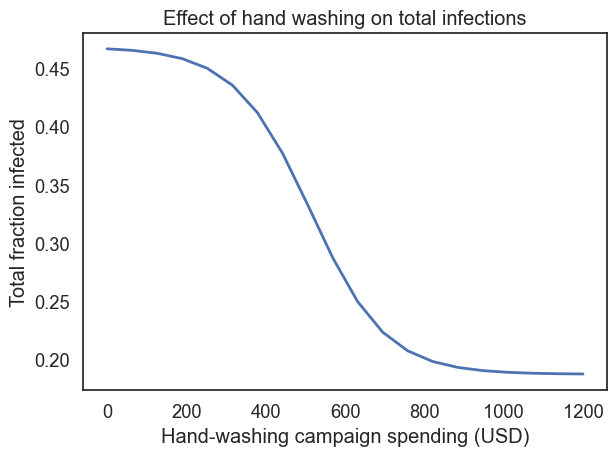

In [32]:

def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)
    
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap12-fig03.pdf')

### Optimization

0 0.9888888888888889 0.26672740341296003 0.1875955039953746
1 0.9777777777777779 0.26683150821044227 0.17458071882622528
2 0.9666666666666667 0.26711285672828566 0.16290983834857686
3 0.9555555555555556 0.2678657473308061 0.15350834947768177
4 0.9444444444444445 0.26982839154517113 0.1485650923152827
5 0.9333333333333333 0.2746135281348078 0.15294595061102179
6 0.9222222222222223 0.28459609475799963 0.1749644150235239
7 0.9111111111111112 0.3 0.21734316168444845
8 0.9 0.3154039052420003 0.2590710444883414
9 0.888888888888889 0.32538647186519215 0.27840288410342784
10 0.8777777777777778 0.33017160845482885 0.2779145346228302
11 0.8666666666666667 0.3321342526691939 0.2673574966927026
12 0.8555555555555556 0.3328871432717143 0.25279694563572175
Saving figure to file figs/chap12-fig04.pdf


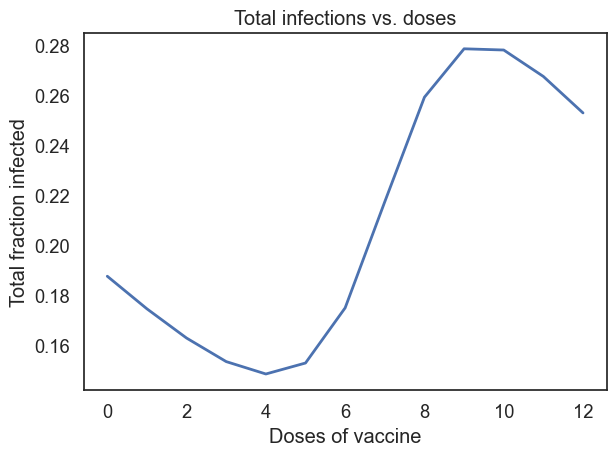

In [33]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

infected_sweep = sweep_doses(dose_array)

plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap12-fig04.pdf')

### Exercises

1. Suppose the price of the vaccine drops to $50 per dose. How does that affect the optimal allocation of the spending?
2. Suppose we have the option to quarantine infected students. For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious. How might you incorporate the effect of quarantine in the SIR model?

Saving figure to file figs/chap12-fig05.pdf


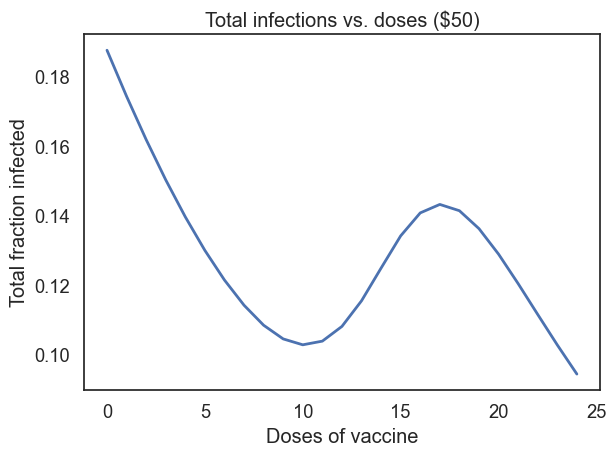

In [34]:
#1.
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)

for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)

infected_sweep = sweep_doses(dose_array)

plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses ($50)',
         legend=False)

savefig('figs/chap12-fig05.pdf')

**1. answer** 

When the price of the vaccine drops to 50 dollars per dose, doses of the vaccine become more economical. With that said, rather than 4 doses of the vaccine at 100 dollars for a total of 400 dollars and a total fraction infected of 0.16, we now allocate 500 dollars for 10 doses of the vaccine for a total fraction infected of 0.10.

**2. answer**

When quarantine is an option for infected students, we have to make assumptions. 

For example, we could assume that all infected students that are put into quarantine, obey orders, do not break quarantine, and so the virus has little-to-no opportunity to spread or we can assume that a certain percent of students will break quarantine regardless and so we perform a sweep on percent of students that break quarantine (ie. midpoint of 20%) and observe the impact on total infected. 

Unless we assume that no students obey quarantine orders, the total percent infected will go down in proportion to the percent of students that obey orders. For modeling this, I would create an `add_quarantine` as well as a `sweep_quarantine` function to be incorporated in the overall model.

Quarantine would reduce the percent that trickle forward from the state of S (susceptible) into the state of I (infected) and down the line into a state of R (recovered).

## Chapter 13

### Sweeping beta

Saving figure to file figs/chap13-fig01.pdf


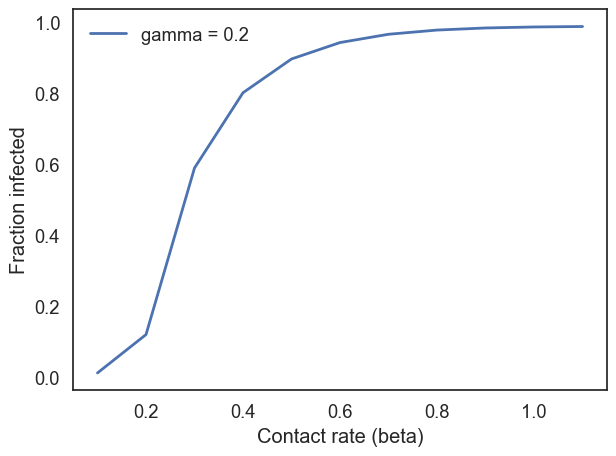

In [36]:
#make a range of values for beta with a constant gamma
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma = 0.2

#wrap a loop in a function and return SweepSeries object
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

infected_sweep = sweep_beta(beta_array, gamma)

label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

savefig('figs/chap13-fig01.pdf')

### Sweeping gamma

Saving figure to file figs/chap13-fig02.pdf


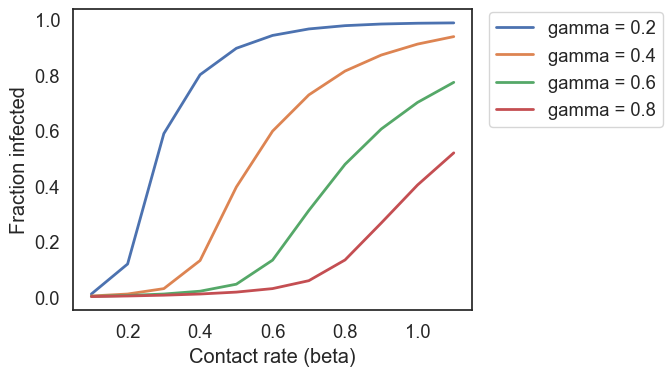

In [37]:
#create an array of values for gamma
gamma_array = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(7, 4))

for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         loc='upper left')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()
savefig('figs/chap13-fig02.pdf')

### Exercise

Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point. Estimate the time between contacts.

Saving figure to file figs/chap13-fig03.pdf


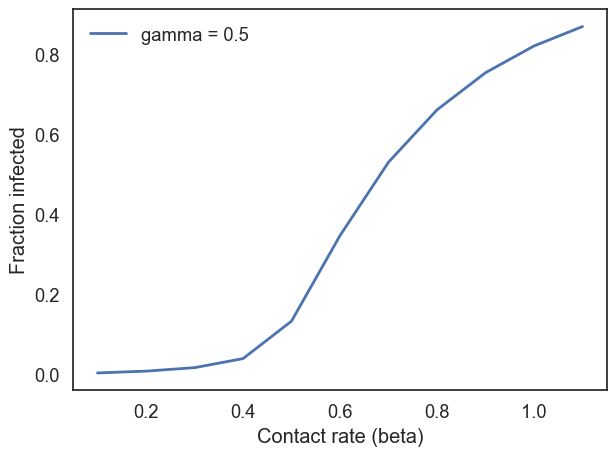

In [41]:
#make a range of values for beta with a constant gamma
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma = 0.5

#wrap a loop in a function and return SweepSeries object
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

infected_sweep = sweep_beta(beta_array, gamma)

label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

savefig('figs/chap13-fig03.pdf')


From the above plot, it appears that 0.4 fraction infected occurs at a contact rate (beta) of ~0.6. We use `np.interp()` to find the exact value and solve for `tc`:

In [48]:
beta_d = np.interp(0.4, infected_sweep.values, beta_array)
tc = 1 / beta_d #derived from beta equation
round(tc,2)

1.59

We see that the time between contacts (`tc`) appears to be ~1.59 days.